In [1]:
# Import all the required libraries
import torch
from torch.utils.data import Dataset
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Define the MNIST training dataset
train_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ]))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
train_loader = torch.utils.data.DataLoader(train_set
    ,batch_size=32
    ,shuffle=True
)

In [4]:
batch = next(iter(train_loader))

In [5]:
images, labels = batch

labels: tensor([7, 2, 1, 0, 5, 7, 2, 8, 5, 4, 2, 5, 8, 0, 4, 0, 0, 7, 9, 9, 5, 2, 2, 7,
        9, 9, 0, 4, 9, 9, 6, 7])


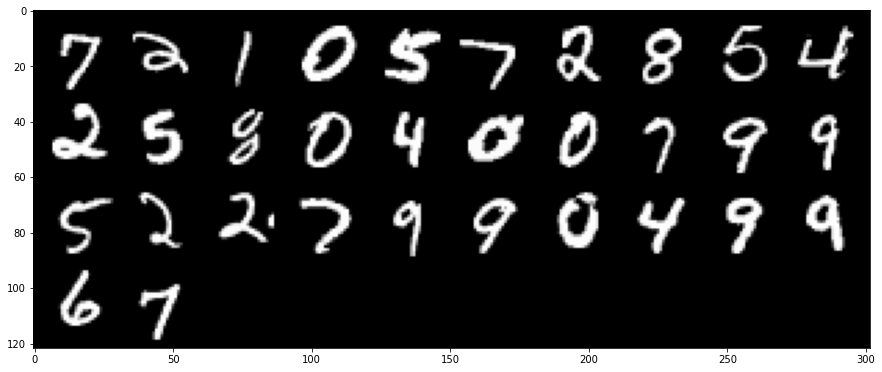

In [6]:
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels)

In [7]:
# Dataset is there to be able to interact with DataLoader
class MyDataset(Dataset):
  def __init__(self):
    self.data = (
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9
    )

  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return len(self.data)

In [8]:
myData = MyDataset()

for m in myData:
  print(m)

0
1
2
3
4
5
6
7
8
9


In [9]:
digit_train_loader = torch.utils.data.DataLoader(myData, batch_size = 2, shuffle=True)

In [10]:
for tr in digit_train_loader:
  print(tr)
  print(F.one_hot(tr, 10))

tensor([8, 4])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])
tensor([6, 1])
tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([5, 3])
tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])
tensor([9, 0])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([2, 7])
tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])


In [12]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

In [13]:
combined_train_loader = torch.utils.data.DataLoader(
             ConcatDataset(
                train_set, myData
             ),
             batch_size=4, shuffle=True)

In [14]:
batch = next(iter(combined_train_loader))

In [15]:
images, nums = batch

In [16]:
images_data, labels = images

In [17]:
nums, labels

(tensor([7, 4, 8, 2]), tensor([3, 9, 1, 4]))

In [18]:
F.one_hot(nums).type(torch.FloatTensor)

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [19]:
nums + labels

tensor([10, 13,  9,  6])

In [28]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    self.fc_rn = nn.Linear(in_features=10, out_features=20)
    self.fc1 = nn.Linear(in_features=12 * 4 * 4 + 20, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=29)
  
  def forward(self, t, n):
    # input layer
    x = t
    num = n
    #print(x, n)

    # conv1 layer
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 28 | 24 | 12

    # conv2 layer
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 12 | 8 | 4 >> 12x4x4

    # reshapre
    x = x.reshape(-1, 12 * 4 * 4)
    #print(x)

    # fc_rn layer
    num = self.fc_rn(num)

    #print(x.shape, num.shape)
    #combine the image and number
    x = torch.cat((x, num), dim=1)

    # fc1 layer
    x = self.fc1(x)
    x = F.relu(x)

    # fc2 layer
    x = self.fc2(x)
    x = F.relu(x)

    # output layer
    x = self.out(x)
    # x = F.softmax(x, dim=1)
    return x

In [29]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [39]:
import torch.optim as optim

network = Network().cuda()
#train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(10):

    total_loss = 0
    total_correct = 0
    total_num_loss = 0
    total_correct_sum = 0

    for batch in combined_train_loader: # Get Batch
        images, nums = batch
        images_data, labels = images
        images = images_data.to('cuda')
        labels = labels.to('cuda')
        nums = nums.to('cuda')
        nums_oh = F.one_hot(nums, 10).to('cuda')
        nums_oh = nums_oh.type(torch.FloatTensor).to('cuda')
        labels_sum = (labels + nums).to('cuda')
        labels_sum_oh = F.one_hot(labels + nums, 19).type(torch.FloatTensor).to('cuda')

        preds = network(images, nums_oh) # Pass Batch
        loss = F.cross_entropy(preds[:,:10], labels) # Calculate Loss
        loss_num = F.mse_loss(preds[:,10:], labels_sum_oh)

        optimizer.zero_grad()
        loss.backward(retain_graph=True) # Calculate Gradients
        loss_num.backward()
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds[:,:10], labels)
        total_num_loss += loss_num.item()
        total_correct_sum += get_num_correct(preds[:,10:], labels_sum)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss,
        "total_correct_sum:", total_correct_sum, 
        "loss_num:", total_num_loss
    )

epoch 0 total_correct: 0 loss: 7.155980587005615 total_correct_sum: 0 loss_num: 0.1654883176088333
epoch 1 total_correct: 2 loss: 6.738234758377075 total_correct_sum: 2 loss_num: 0.14695844799280167
epoch 2 total_correct: 3 loss: 6.338948011398315 total_correct_sum: 2 loss_num: 0.1469663605093956
epoch 3 total_correct: 3 loss: 5.9650198221206665 total_correct_sum: 2 loss_num: 0.2550387606024742
epoch 4 total_correct: 4 loss: 5.1955626010894775 total_correct_sum: 3 loss_num: 0.16182010248303413
epoch 5 total_correct: 5 loss: 5.068055748939514 total_correct_sum: 3 loss_num: 0.1583581380546093
epoch 6 total_correct: 3 loss: 4.530834674835205 total_correct_sum: 0 loss_num: 0.1715369112789631
epoch 7 total_correct: 3 loss: 4.513128638267517 total_correct_sum: 3 loss_num: 0.14518538489937782
epoch 8 total_correct: 4 loss: 3.3694562911987305 total_correct_sum: 4 loss_num: 0.1504092961549759
epoch 9 total_correct: 5 loss: 2.9816866517066956 total_correct_sum: 6 loss_num: 0.15306370705366135
